In [145]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns 
from noise import pnoise2
import PIL.Image
from tqdm.auto import tqdm

from typing import Tuple

from IPython.core.pylabtools import print_figure
from IPython.display import Image, SVG, Math
from IPython.display import (
    display, display_html, display_png, display_svg
)


/home/janrei/infinitile/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Size: (0, 1). Avg: -0.008. Range: [-0.45, 0.46]

Size: (0, 1). Avg: -0.004. Range: [-0.43, 0.34]

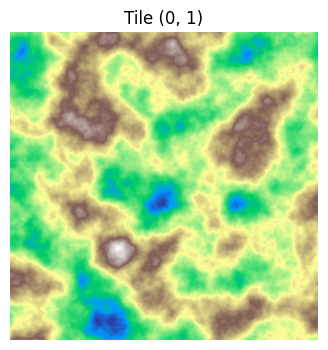

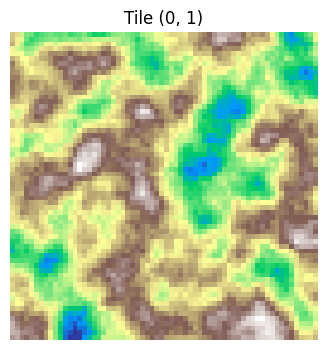

/tmp/ipykernel_192596/2694797637.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


In [146]:
class Tile():

    def __init__(self, coord: Tuple[int, int] = (0, 0), size: int = 64, scale: float = 0.06, octaves: int=12, 
                    map_seed: Tuple[float, float] = (0, 0)):

        self.size = size
        self.coord = coord
        self.scale = scale
        self.octaves = 12
        self.map_seed = map_seed

        self.grid = self.generate_base_heightmap()

    def generate_base_heightmap(self):

        x_off = self.map_seed[0] + self.coord[0] * self.size 
        y_off = self.map_seed[0] + self.coord[1] * self.size
        
        return np.array([
            [pnoise2((x + x_off) * self.scale, (y + y_off) * self.scale, octaves=self.octaves, repeatx=999999, repeaty=999999)
            for x in range(self.size)]
            for y in range(self.size)
        ])

    @staticmethod
    def blend_edges(heightmap, north=None, west=None, blend_width=5):
        if north is not None:
            heightmap[0, :] = north
            for i in range(1, blend_width):
                alpha = i / blend_width
                heightmap[i, :] = (1 - alpha) * north + alpha * heightmap[i, :]
        if west is not None:
            heightmap[:, 0] = west
            for i in range(1, blend_width):
                alpha = i / blend_width
                heightmap[:, i] = (1 - alpha) * west + alpha * heightmap[:, i]
        return heightmap

    def _repr_html_(self) -> str:
        html = f"Size: {self.coord}. Avg: {np.mean(self.grid):.3f}. Range: [{np.min(self.grid):.2f}, {np.max(self.grid):.2f}]"
        return html

    def _repr_json_(self) -> dict:
        return {"size": self.coord, "grid": self.grid.tolist()}

    def _figure_data(self, format):
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(self.grid, cmap='terrain')
        ax.set_title(f"Tile {self.coord}")
        ax.axis('off')
        data = print_figure(fig, format)
        plt.close(fig)
        return data

    def _repr_png_(self):
        return self._figure_data('png')

    def _repr_svg_(self) -> str:
        raise NotImplementedError
        
    def save_tile_as_png(self, path: str, colormap='terrain'):

        array = self.grid

        """Save a 2D float array as an RGB image using a matplotlib colormap."""
        # Normalize array to [0,1]
        norm_array = (array - np.min(array)) / (np.ptp(array) + 1e-8)

        # Apply colormap and strip alpha
        cmap = cm.get_cmap(colormap)
        rgba = cmap(norm_array)  # shape (H, W, 4), float64
        rgb = (rgba[:, :, :3] * 255).astype(np.uint8)  # Convert to 8-bit

        assert rgb.shape[:2] == array.shape, "Output size mismatch!"

        # Create and save image
        im = PIL.Image.fromarray(rgb, mode='RGB')
        im.save(path)

t = Tile(size=1024, scale=0.004, 
            coord=(0, 1), map_seed=(100, 100))
t2 = Tile(coord=(0, 1), map_seed=(100, 100))

display_html(t)
display_html(t2)

display_png(t)
display_png(t2)

t.save_tile_as_png(path="out.png")


Size: (0, 0). Avg: 0.455. Range: [0.00, 0.83]

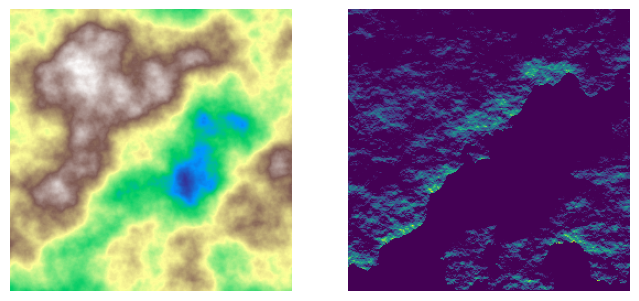

100%|██████████| 50/50 [00:02<00:00, 17.18it/s]


'0.46; Range: [0.00, 0.83]'

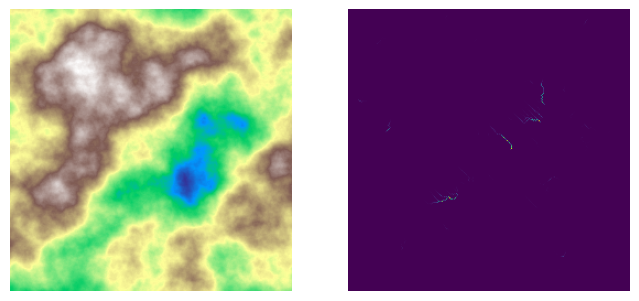

100%|██████████| 50/50 [00:02<00:00, 17.49it/s]


'0.46; Range: [0.00, 0.83]'

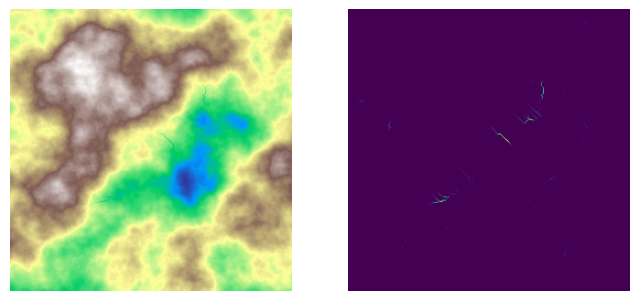

100%|██████████| 50/50 [00:02<00:00, 17.63it/s]


'0.46; Range: [0.00, 0.83]'

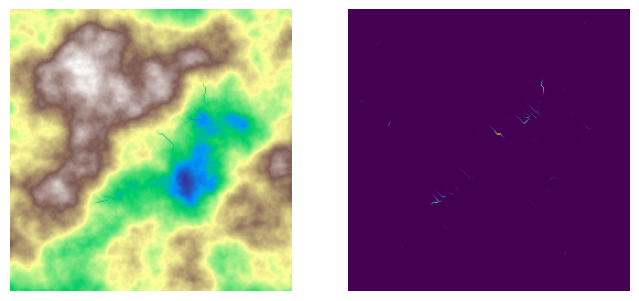

100%|██████████| 50/50 [00:02<00:00, 17.63it/s]


'0.46; Range: [0.00, 0.83]'

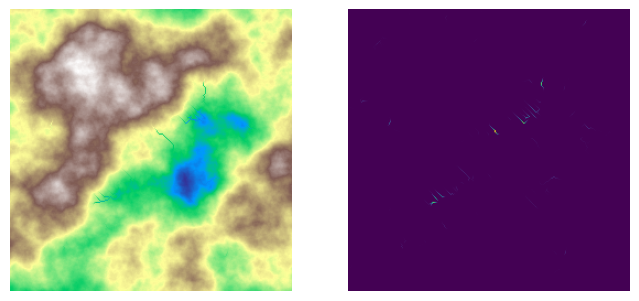

100%|██████████| 50/50 [00:02<00:00, 17.29it/s]


'0.46; Range: [0.00, 0.83]'

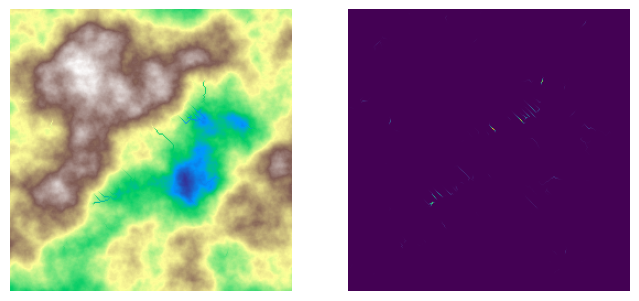

100%|██████████| 50/50 [00:02<00:00, 17.48it/s]


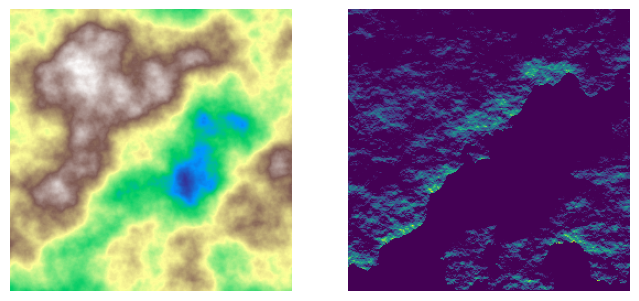

In [185]:
class WaterSimulator:
    def __init__(self, elevation: np.ndarray, wind_dir: str = 'west', flow_steps: int = 10):
        """Initialize with an elevation map and prevailing wind direction."""
        self.elevation = elevation.copy()
        self.wind_dir = wind_dir
        self.flow_steps = flow_steps
        self.precipitation = self.compute_precipitation()
        self.flow_dir = None
        self.flow_accum = None
        self.erosion_map = None
        self.total_erosion = np.zeros_like(self.elevation)

    def compute_precipitation(self) -> np.ndarray:
        """Simulate precipitation based on wind direction, elevation, and dew point."""
        def rotate(array, k):
            return np.rot90(array, k=k)

        def unrotate(array, k):
            return np.rot90(array, k=-k)

        wind_rotation = {
            'west': 0,
            'north': 1,
            'east': 2,
            'south': 3
        }.get(self.wind_dir, 0)

        elev = rotate(self.elevation, wind_rotation)
        H, W = elev.shape

        dew_point = 0.4
        humidity = np.ones(H)
        precipitation_rot = np.zeros((H, W))

        for x in range(W):
            slope = elev[:, x] - elev[:, x - 1] if x > 0 else np.zeros(H)
            rainfall = np.zeros(H)
            for y in range(H):
                if elev[y, x] > dew_point and slope[y] > 0:
                    rainfall[y] = slope[y] * humidity[y]
                    humidity[y] = max(humidity[y] - rainfall[y], 0.0)
            precipitation_rot[:, x] = rainfall

        precipitation = unrotate(precipitation_rot, wind_rotation)
        return precipitation

    def compute_flow_direction(self):
        """Compute steepest downhill direction for each cell."""
        H, W = self.elevation.shape
        self.flow_dir = np.zeros((H, W, 2), dtype=int)
        for y in range(1, H - 1):
            for x in range(1, W - 1):
                min_h = self.elevation[y, x]
                dy_dx = (0, 0)
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        if dy == 0 and dx == 0:
                            continue
                        nh = self.elevation[y + dy, x + dx]
                        if nh < min_h:
                            min_h = nh
                            dy_dx = (dy, dx)
                self.flow_dir[y, x] = dy_dx

    def compute_flow_accumulation(self):
        """Iteratively accumulate flow based on direction and rainfall."""
        H, W = self.elevation.shape
        self.flow_accum = self.precipitation.copy()
        for _ in tqdm(range(self.flow_steps)):
            new_flow = np.zeros_like(self.flow_accum)
            for y in range(1, H - 1):
                for x in range(1, W - 1):
                    dy, dx = self.flow_dir[y, x]
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < H and 0 <= nx < W:
                        new_flow[ny, nx] += self.flow_accum[y, x]
            self.flow_accum += new_flow

    def compute_erosion(self, erosion_strength=0.01, flow_threshold=5.0, max_erosion_per_step=0.05):
        """Erode only in regions with significant flow accumulation and steep slope."""
        H, W = self.elevation.shape
        slope = np.zeros((H, W))

        for y in range(1, H - 1):
            for x in range(1, W - 1):
                dy, dx = self.flow_dir[y, x]
                ny, nx = y + dy, x + dx
                if 0 <= ny < H and 0 <= nx < W:
                    dz = self.elevation[y, x] - self.elevation[ny, nx]
                    slope[y, x] = max(dz, 0.0)

        erosion_force = self.flow_accum * slope
        norm_force = erosion_force / (np.max(erosion_force) + 1e-8)

        erosion = np.zeros_like(self.elevation)
        mask = self.flow_accum > flow_threshold
        erosion[mask] = norm_force[mask] * erosion_strength
        erosion = np.minimum(erosion, max_erosion_per_step)

        self.erosion_map = erosion
        self.elevation -= erosion
        self.total_erosion += erosion

    def step(self):
        """Perform one cycle: flow → accumulation → erosion."""
        self.compute_flow_direction()
        self.compute_flow_accumulation()
        self.compute_erosion()

    def get_results(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        return self.elevation, self.flow_accum, self.erosion_map

    def _figure_data(self, format):
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

        ax0.imshow(self.elevation, cmap='terrain')

        erosion = self.erosion_map / np.max(self.erosion_map)
        ax1.imshow(erosion)

        ax0.axis('off')
        ax1.axis('off')

        data = print_figure(fig, format)
        plt.close(fig)
        return data

    def _repr_png_(self):
        return self._figure_data('png')


t = Tile(size=256, scale=0.009, coord=(0, 0), map_seed=(100, 100))
t.grid += np.abs(np.min(t.grid))

display_html(t)

WS = WaterSimulator(elevation=t.grid, wind_dir='south', flow_steps=50)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

ax0.imshow(WS.elevation, cmap='terrain')
ax1.imshow(WS.precipitation)

ax0.axis('off')
ax1.axis('off')

display(fig)

#break

for step_ in range(50):
    WS.step()

    if step_ % 10 == 0:
        display(f"{np.mean(WS.elevation):.2f}; Range: [{np.min(WS.elevation):.2f}, {np.max(WS.elevation):.2f}]")
        display_png(WS)


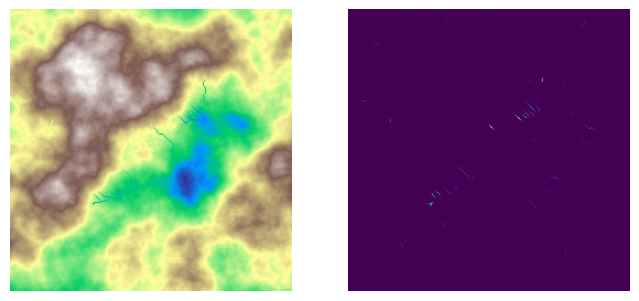

In [187]:
display_png(WS)
